<a href="https://colab.research.google.com/github/b21renu/IOTEC-Tic-Tac-Toe/blob/main/TicTacToe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This file was taken to be taught in the class Section 7A
# File source: Ses7A_Cars_Classify_TFLite.ipynb
# Car dataset is downloaded from the website below.
# https://archive.ics.uci.edu/dataset/19/car+evaluation
# Keep the car.data file downloaded, in the same directory as this ipynb file

# Classification model using TF 2.0 to model the usefulness of cars
# Ref: https://stackabuse.com/tensorflow-2-0-solving-classification-and-regression-problems/
# Data files of cars: https://archive.ics.uci.edu/dataset/19/car+evaluation
# Ref2 Book: Giancarlo Zaccone, Getting Started with TensorFlow-Packt Publishing (2016)
# Chapter 3 on Classifiers
# Ref for matplotlib: https://www.tutorialspoint.com/matplotlib/index.htm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
path = '/content/drive/MyDrive/SEM-5/IOT&EC/TicTacToe'
os.chdir(path)
print("Current Directory:", os.getcwd())

Current Directory: /content/drive/MyDrive/SEM-5/IOT&EC/TicTacToe


In [ ]:
!nvidia-smi # For GPU memory usage, if using GPU runtime
!free -h    # For RAM usage

/bin/bash: line 1: nvidia-smi: command not found
               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.1Gi       9.2Gi       2.0Mi       2.3Gi        11Gi
Swap:             0B          0B          0B


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

In [ ]:
# Different categorical values of each of the 9 attributes are given below, in total 27

# Individual attribute values are given as below:
# top-left-square: {x,o,b}
# top-middle-square: {x,o,b}
# top-right-square: {x,o,b}
# middle-left-square: {x,o,b}
# middle-middle-square: {x,o,b}
# middle-right-square: {x,o,b}
# bottom-left-square: {x,o,b}
# bottom-middle-square: {x,o,b}
# bottom-right-square: {x,o,b}
# x=player x has taken, o=player o has taken, b=blank

# Output Categories are: positive, negative
cols = ['top-left-square', 'top-middle-square', 'top-right-square', 'middle-left-square', 'middle-middle-square', 'middle-right-square', 'bottom-left-square', 'bottom-middle-square', 'bottom-right-square', 'Class']

# Import the CSV file to Panda's DataFrame format.
ttt = pd.read_csv(r'tic-tac-toe.data', names=cols, header=None)
print(cols,'\n')
print(ttt) # A DataFrame object

['top-left-square', 'top-middle-square', 'top-right-square', 'middle-left-square', 'middle-middle-square', 'middle-right-square', 'bottom-left-square', 'bottom-middle-square', 'bottom-right-square', 'Class'] 

    top-left-square top-middle-square top-right-square middle-left-square  \
0                 x                 x                x                  x   
1                 x                 x                x                  x   
2                 x                 x                x                  x   
3                 x                 x                x                  x   
4                 x                 x                x                  x   
..              ...               ...              ...                ...   
953               o                 x                x                  x   
954               o                 x                o                  x   
955               o                 x                o                  x   
956               o 

In [ ]:
ttt.head()

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,Class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [ ]:
ttt.shape

(958, 10)

In [ ]:
plot_size = plt.rcParams["figure.figsize"]
plot_size [0] = 10 #8
plot_size [1] = 10 #6
plt.rcParams["figure.figsize"] = plot_size

<Axes: ylabel='count'>

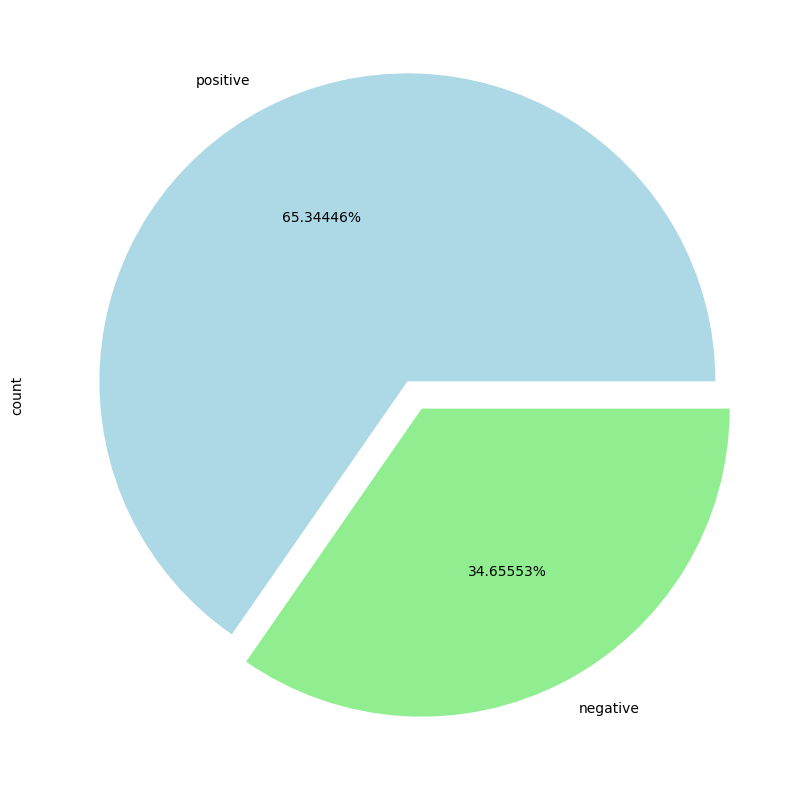

In [ ]:
# Get the number of unique values in the 'Class' column
num_classes = len(ttt.Class.value_counts())

# Create an explode array with the same length as the number of classes
explode = [0.05] * num_classes

# Plot the pie chart with the updated explode array
ttt.Class.value_counts().plot(kind='pie', autopct='%0.05f%%',
                                colors=['lightblue', 'lightgreen', 'orange', 'pink', 'red', 'yellow', 'brown', 'gray', 'purple', 'cyan'],  # Add more colors if necessary
                                explode=explode)

In [ ]:
# Convert categorical columns to dummy variables, renaming appropriately
# The get_dummies function in pandas is used to convert categorical variables into a series of binary (0 or 1) columns.
# This process, called one-hot encoding, is often necessary for machine learning models, as they require numerical input.
top_left = pd.get_dummies(ttt['top-left-square'], prefix='top_left')
top_middle = pd.get_dummies(ttt['top-middle-square'], prefix='top_middle')
top_right = pd.get_dummies(ttt['top-right-square'], prefix='top_right')
middle_left = pd.get_dummies(ttt['middle-left-square'], prefix='middle_left')
middle_middle = pd.get_dummies(ttt['middle-middle-square'], prefix='middle_middle')
middle_right = pd.get_dummies(ttt['middle-right-square'], prefix='middle_right')
bottom_left = pd.get_dummies(ttt['bottom-left-square'], prefix='bottom_left')
bottom_middle = pd.get_dummies(ttt['bottom-middle-square'], prefix='bottom_middle')
bottom_right = pd.get_dummies(ttt['bottom-right-square'], prefix='bottom_right')
labels = pd.get_dummies(ttt.Class, prefix='condition')

In [ ]:
# For the output or target variable, typically it's named `Class` in this setup
# labels = pd.get_dummies(ttt['Class'], prefix='Class')

# Concatenate the dummy variables to create the full dataset
final_data = pd.concat([top_left, top_middle, top_right,
                        middle_left, middle_middle, middle_right,
                        bottom_left, bottom_middle, bottom_right], axis=1)

print(final_data)

     top_left_b  top_left_o  top_left_x  top_middle_b  top_middle_o  \
0         False       False        True         False         False   
1         False       False        True         False         False   
2         False       False        True         False         False   
3         False       False        True         False         False   
4         False       False        True         False         False   
..          ...         ...         ...           ...           ...   
953       False        True       False         False         False   
954       False        True       False         False         False   
955       False        True       False         False         False   
956       False        True       False         False         False   
957       False        True       False         False          True   

     top_middle_x  top_right_b  top_right_o  top_right_x  middle_left_b  ...  \
0            True        False        False         True          F

In [ ]:
final_data.shape

(958, 27)

In [ ]:
top_left.head()

,top_left_b,top_left_o,top_left_x
0,False,False,True
1,False,False,True
2,False,False,True
3,False,False,True
4,False,False,True


In [ ]:
top_middle.head()

,top_middle_b,top_middle_o,top_middle_x
0,False,False,True
1,False,False,True
2,False,False,True
3,False,False,True
4,False,False,True


In [ ]:
top_right.head()

,top_right_b,top_right_o,top_right_x
0,False,False,True
1,False,False,True
2,False,False,True
3,False,False,True
4,False,False,True


In [ ]:
middle_left.head()

,middle_left_b,middle_left_o,middle_left_x
0,False,False,True
1,False,False,True
2,False,False,True
3,False,False,True
4,False,False,True


In [ ]:
middle_middle.head()

,middle_middle_b,middle_middle_o,middle_middle_x
0,False,True,False
1,False,True,False
2,False,True,False
3,False,True,False
4,False,True,False


In [ ]:
middle_right.head()

,middle_right_b,middle_right_o,middle_right_x
0,False,True,False
1,False,True,False
2,False,True,False
3,False,True,False
4,False,True,False


In [ ]:
bottom_left.head()

,bottom_left_b,bottom_left_o,bottom_left_x
0,False,False,True
1,False,True,False
2,False,True,False
3,False,True,False
4,True,False,False


In [ ]:
bottom_middle.head()

,bottom_middle_b,bottom_middle_o,bottom_middle_x
0,False,True,False
1,False,False,True
2,False,True,False
3,True,False,False
4,False,True,False


In [ ]:
bottom_right.head()

,bottom_right_b,bottom_right_o,bottom_right_x
0,False,True,False
1,False,True,False
2,False,False,True
3,True,False,False
4,True,False,False


In [ ]:
y = labels.values
print(y)

[[False  True]
 [False  True]
 [False  True]
 ...
 [ True False]
 [ True False]
 [ True False]]


In [ ]:
from sklearn.model_selection import train_test_split

print(final_data.shape)
print(y.shape)

(958, 27)
(958, 2)


In [ ]:
# The total data in the dataset is 958, 20% of them is: 192 (no. of test data)
# Size of train data: 958 - 766 = 192
# random_state is a seed. It can be any value. If we keep it same on every run, then there will be repeatability in the results.
X_train, X_test, y_train, y_test = train_test_split(final_data, y, test_size=0.20, random_state=42)
print('Shape of X_train and X_test:', X_train.shape, X_test.shape)
print('Shape of y_train and y_test:', y_train.shape, y_test.shape)

Shape of X_train and X_test: (766, 27) (192, 27)
Shape of y_train and y_test: (766, 2) (192, 2)


In [ ]:
# Define the number of nodes in each layer of the network
# Layer1 with 24 and Layer2 with 16 nodes is better than 16 and 24 respectively.
DENSE1_SIZE = 24
DENSE2_SIZE = 20
NUM_OF_EPOCHS = 50
BATCH_SIZE = 24
DROPOUT_RATE = 0.2
L2_REGULARIZATION = 0.001

# Define the model architecture
model = tf.keras.Sequential()

In [ ]:
# Due to hot encoding the inputs for each category dependes on no. of Different categories defined for each feature.
# So, the total categories are: 3 + 3 + 3 + 3 + 3 + 3 + 3 + 3 + 3 + 3 + 2 = 29 inputs
input_shape = final_data.shape[1]
print(input_shape)

27


In [ ]:
model.add(tf.keras.layers.Flatten(input_shape=(input_shape,)))

# First dense layer with L2 regularization and dropout
# If DENSE1_SIZE = 20, total number of parameters = (20 * input_shape) weights + 20 biases
# For example, if input_shape is 29, total params = 20 * 29 weights + 20 biases = 580 + 20 = 600
model.add(tf.keras.layers.Dense(DENSE1_SIZE, activation='relu', kernel_regularizer=l2(L2_REGULARIZATION)))
model.add(Dropout(DROPOUT_RATE))

# Second dense layer with L2 regularization and dropout
# If DENSE2_SIZE = 10, total number of parameters = (DENSE1_SIZE * DENSE2_SIZE) weights + 10 biases
# For example, if DENSE1_SIZE = 20, total params = 10 * 20 weights + 10 biases = 200 + 10 = 210
model.add(tf.keras.layers.Dense(DENSE2_SIZE, activation='relu', kernel_regularizer=l2(L2_REGULARIZATION)))
model.add(Dropout(DROPOUT_RATE))

# Output layer for multi-class classification with softmax activation
# Assuming there are 4 output classes (e.g., "acc", "good", "unacc", "vgood")
# Total parameters = (DENSE2_SIZE * number of classes) weights + biases
# If DENSE2_SIZE = 10 and 4 output classes, total params = 10 * 4 weights + 4 biases = 40 + 4 = 44
output_shape = y.shape[1]
print("Output Shape:", output_shape)

Output Shape: 2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.add(tf.keras.layers.Dense(output_shape, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 24)                  │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,214 (4.74 KB)

 Trainable params: 1,214 (4.74 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# With epchs 50, the output results where not matching with the expected results
# No need to make those changes because accuracy is achieved with the initial values itself
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_OF_EPOCHS,
    verbose=1,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4915 - loss: 0.7766 - val_accuracy: 0.6299 - val_loss: 0.6829
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5827 - loss: 0.7205 - val_accuracy: 0.7013 - val_loss: 0.6476
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6466 - loss: 0.6761 - val_accuracy: 0.7013 - val_loss: 0.6340
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6324 - loss: 0.6606 - val_accuracy: 0.7208 - val_loss: 0.6203
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7098 - loss: 0.6291 - val_accuracy: 0.7403 - val_loss: 0.6093
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6933 - loss: 0.6170 - val_accuracy: 0.7468 - val_loss: 0.5993
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7012 - loss: 0.5921 - val_accuracy: 0.7208 - val_loss: 0.5920
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7385 - loss: 0.5925 - val_accuracy: 0.7143 - val_loss

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9761 - loss: 0.1688 
Test Score: 0.16181156039237976
Test Accuracy: 0.9791666865348816


In [ ]:
# Trying out saving the model in h5 file format
# Ref: https://www.tensorflow.org/tutorials/keras/save_and_load
# We have the model object that needs to be saved
# It save text file with Hex numbers in HDF5 format in the current dir
# This model file has a size of 39.52 KB
model.save('TicTacToeModel.h5')

In [ ]:
model.save('TicTacToe.keras')

In [ ]:
def representative_dataset():
    for _ in range(100):
      data =  X_test
      yield [data.astype(np.float32)]

print(representative_dataset())

<generator object representative_dataset at 0x7edc6c381e70>


In [ ]:
import tensorflow as tf

# Step 1: Save the model to the SavedModel format
tf.saved_model.save(model, "TicTacToeModel")
print("saved")

saved


In [ ]:
# Step 2: Load the model and initialize the TFLite converter
converter = tf.lite.TFLiteConverter.from_saved_model("TicTacToeModel")
print("converter")

converter


In [ ]:
# Step 3: Remove optimizations if they are not necessary for ESP32 compatibility
# This step is optional, depending on your needs
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [ ]:
# Step 4: Add representative dataset function
# Ensure the function yields data in the required shape and data type
converter.representative_dataset = representative_dataset
print("dataset")

dataset


In [ ]:
import tensorflow as tf
import traceback

# Enable debug logging
tf.debugging.set_log_device_placement(True)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.DEBUG)

In [ ]:
import tensorflow as tf

# Assuming 'model' is your Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional optimizations
tflite_model = converter.convert()

# Save the model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpsd2lhnur/assets


Saved artifact at '/tmp/tmpsd2lhnur'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 27), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  139485260413440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139485260448688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139485236154032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139485236156848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139485236160368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139485236164592: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
# Run the inference on TFLITE model on Python ... here itself first
# Let us now first try to run this tflinte model on Python itself
# Ref: https://www.tensorflow.org/lite/guide/inference
# Load the TFLite model and allocate tensors.
# interpreter = tf.lite.Interpreter(model_path="CarsClassifyModel.tflite")
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

In [ ]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print('input_details:\n', input_details)
print('output_details:\n', output_details)

input_details:
 [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([ 1, 27], dtype=int32), 'shape_signature': array([-1, 27], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
output_details:
 [{'name': 'StatefulPartitionedCall_1:0', 'index': 12, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
# Now set the input data and invoke
input_shape = input_details[0]['shape']
input0_data = np.random.random_sample(input_shape).astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], input0_data)
print(input0_data)

[[0.07571106 0.93017256 0.796927   0.4179782  0.92827797 0.8723658
  0.56326103 0.6795611  0.40587205 0.40921962 0.11746109 0.3452706
  0.5628354  0.30698124 0.35019532 0.7367     0.36511427 0.8933257
  0.31386584 0.58394223 0.24577513 0.90165937 0.19460109 0.59802634
  0.88454074 0.8081986  0.75210404]]


In [ ]:
# Invoke the interpreter
try:
    interpreter.invoke()
    output_details = interpreter.get_output_details()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print(output_data)
except RuntimeError as e:
    print("Error during inference:", e)

[[0.93643606 0.06356395]]


In [ ]:
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output0_data = interpreter.get_tensor(output_details[0]['index'])
print(output0_data)

# Verify if the same data is given to the original model what is the output
output0_data = model.predict(input0_data)
print(output0_data)

[[0.93643606 0.06356395]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
[[0.93643606 0.06356399]]


In [ ]:
# ['top-left-square', 'top-middle-square', 'top-right-square', 'middle-left-square', 'middle-middle-square', 'middle-right-square', 'bottom-left-square', 'bottom-middle-square', 'bottom-right-square']
# The input data needs to have 27 features
input1_data = [[1.0, 0.0, 0.0,
                0.0, 1.0, 0.0,
                0.0, 0.0, 1.0,
                1.0, 0.0, 0.0,
                0.0, 1.0, 0.0,
                0.0, 0.0, 1.0,
                1.0, 0.0, 0.0,
                0.0, 1.0, 0.0,
                0.0, 0.0, 1.0]]
# print(input1_data)
input1_data = np.array(input1_data, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input1_data)

interpreter.invoke()
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output1_data = interpreter.get_tensor(output_details[0]['index'])
print('output1:')
print(output1_data)

# Verify if the same data is given to the original model what is the output
output1_data = model.predict(input1_data)
print(output1_data)

output1:
[[0.7456629  0.25433713]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[0.74566287 0.25433713]]


In [ ]:
input2_data = [[0.0, 1.0, 0.0,
                1.0, 0.0, 0.0,
                0.0, 1.0, 0.0,
                0.0, 0.0, 1.0,
                1.0, 0.0, 0.0,
                0.0, 1.0, 0.0,
                0.0, 0.0, 1.0,
                1.0, 0.0, 0.0,
                0.0, 1.0, 0.0]]
print(input2_data)
input2_data = np.array(input2_data, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input2_data)

interpreter.invoke()
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output2_data = interpreter.get_tensor(output_details[0]['index'])
# print('output2:')
print(output2_data)

# Verify if the same data is given to the original model what is the output
output2_data = model.predict(input2_data)
print(output2_data)

[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]]
[[9.9957937e-01 4.2067244e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
[[9.9957937e-01 4.2067247e-04]]


In [ ]:
input3_data = [[1.0, 0.0, 0.0,
                0.0, 0.0, 1.0,
                0.0, 1.0, 0.0,
                1.0, 0.0, 0.0,
                1.0, 0.0, 0.0,
                0.0, 1.0, 0.0,
                1.0, 0.0, 0.0,
                0.0, 0.0, 1.0,
                1.0, 0.0, 0.0]]
print(input3_data)
input3_data = np.array(input3_data, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input3_data)

interpreter.invoke()
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output3_data = interpreter.get_tensor(output_details[0]['index'])
# print('output2:')
print(output3_data)

# Verify if the same data is given to the original model what is the output
output3_data = model.predict(input3_data)
print(output3_data)

[[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]]
[[0.89246976 0.10753021]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[0.8924699  0.10753016]]


In [ ]:
input4_data = [[0.0, 0.0, 1.0,
                1.0, 0.0, 0.0,
                0.0, 1.0, 0.0,
                0.0, 1.0, 1.0,
                1.0, 0.0, 0.0,
                1.0, 0.0, 1.0,
                0.0, 0.0, 1.0,
                1.0, 0.0, 0.0,
                0.0, 1.0, 0.0]]
print(input4_data)

# Convert input4_data to a NumPy array
input4_data = np.array(input4_data, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input4_data)

# Invoke the interpreter
interpreter.invoke()

# Retrieve and print the output for input4_data
output4_data = interpreter.get_tensor(output_details[0]['index'])
print('Output4 from interpreter:')
print(output4_data)

# Verify output using the original model
output4_data_model = model.predict(input4_data)
print('Output4 from model.predict:')
print(output4_data_model)


[[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]]
Output4 from interpreter:
[[0.00721783 0.9927821 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Output4 from model.predict:
[[0.00721783 0.9927821 ]]


In [ ]:
# Function to convert some hex values into an array for C programming
import time, sys

# Function to convert some hex values into an array for C programming
def hex_to_c_array(hex_data, var_name):
    c_str = ""

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += "#define " + var_name.upper() + '_H\n\n'

    c_str += "/*\n Author: Mouli Sankaran \n"
    c_str += " CAUTION: This is an auto generated file.\n DO NOT EDIT OR MAKE ANY CHANGES TO IT.\n"

# Time stamping of this model data in the generated file
    localtime = time.asctime( time.localtime(time.time()) )
    c_str += " This model data was generated on " + localtime+ '\n\n'
    print("This model data was generated on:", localtime)

# Add information about the verisons of tools and packages used in generating this header file
    c_str += " Tools used:\n Python:" + str(sys.version) + "\n Numpy:" + str(np.version.version) + \
          "\n TensorFlow:" + str(sys.version) + "\n Keras: "+ str(tf.keras.__version__) + "\n\n"
    print("Tools used: Python:", sys.version, "\n Numpy:", np.version.version, \
          "\n TensorFlow:", sys.version, "\n Keras: ", tf.keras.__version__, "\n\n")

# Training details of the model
    c_str += ' Model details are:*/\n'
    c_str += '\nconst int ' + ' NUM_OF_EPOCHS = ' + str(NUM_OF_EPOCHS) + ';\n'
    c_str += '\nconst int ' + ' BATCH_SIZE    = ' + str(BATCH_SIZE) + ';\n\n'

# Generate 'C' constants for the no. of nodes in each layer
    c_str += '\nconst int ' + 'DENSE1_SIZE' + ' = ' + str(DENSE1_SIZE) + ';\n'
    c_str +=   'const int ' + 'DENSE2_SIZE' + ' = ' + str(DENSE2_SIZE) + ';\n'

    # Add array length at the top of the file
    c_str += '\nconst unsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

    # Declare C variable
    c_str += 'alignas(8) const unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data):
        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formating so each line stays within 80 characters
        if (i + 1) < len(hex_data):
          hex_str += ','
        if (i + 1) % 12 == 0:
          hex_str += '\n'
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n' + format(''.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

In [ ]:
# Write TFLite model to a C source (or header) file
with open("TicTacToe_model_esp32" + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, "TicTacToe_model_esp32"))

This model data was generated on: Sun Nov 10 16:17:12 2024
Tools used: Python: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0] 
 Numpy: 1.26.4 
 TensorFlow: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0] 
 Keras:  3.4.1 


